Using Open AI text embedding to visualize the representations of the scenarios in a language space.

In [34]:
#!pip install --upgrade openai
#!pip install umap-learn
#!pip install openpyxl

   ---------------------------------------- 0.0/250.9 kB ? eta -:--:--
   - -------------------------------------- 10.2/250.9 kB ? eta -:--:--
   ---- ---------------------------------- 30.7/250.9 kB 435.7 kB/s eta 0:00:01
   ----------- --------------------------- 71.7/250.9 kB 491.5 kB/s eta 0:00:01
   --------------- ---------------------- 102.4/250.9 kB 590.8 kB/s eta 0:00:01
   -------------------------- ----------- 174.1/250.9 kB 751.6 kB/s eta 0:00:01
   ----------------------------------- -- 235.5/250.9 kB 850.1 kB/s eta 0:00:01
   -------------------------------------- 250.9/250.9 kB 771.4 kB/s eta 0:00:00



[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!pip install kneed

ERROR: Could not find a version that satisfies the requirement kneed (from versions: none)
ERROR: No matching distribution found for kneed


# Import libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances, silhouette_score
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import KMeans
from kneed import KneeLocator
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram,fcluster
from scipy import stats
import matplotlib.pyplot as plt
from adjustText import adjust_text
import umap
import seaborn as sns
import random
from sklearn.preprocessing import LabelEncoder
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from openai import OpenAI
from ast import literal_eval


ModuleNotFoundError: No module named 'kneed'

# Load Scenario Narratives

In [6]:
data = pd.read_csv('data/Narratives_all.csv') # this spreadsheet is updated with the finalized scenario descriptions

In [4]:
# average length of the scenarios
data['word_count'] = data['Scenario'].apply(lambda x: len(x.split()))

# Calculate the min, max, and average
min_count = data['word_count'].min()
max_count = data['word_count'].max()
average_count = data['word_count'].mean()

min_count, max_count, average_count

(33, 76, 48.39)

# Decision Space

In [8]:
# load data
Task1_filtered = pd.read_csv('data/Task1_Final.csv')
scenario_summary = pd.read_csv('output/Task1_scenario_summary.csv',index_col = 0)
scenario_summary.index = [f'S{i}' for i in range(1,101)]
scenario_summary

,mean,SD,n,help_prop,SD_prop
S1,3.730769,1.891374,104,0.961538,0.193239
S2,0.067961,2.948120,103,0.553398,0.499571
S3,2.154639,2.884370,97,0.783505,0.413995
S4,-2.301887,2.589980,106,0.226415,0.420499
S5,3.099010,2.504017,101,0.891089,0.313081
...,...,...,...,...,...
S96,1.912621,2.811415,103,0.796117,0.404853
S97,4.102804,1.380009,107,0.981308,0.136071
S98,2.106796,2.920222,103,0.776699,0.418495
S99,3.457143,2.324736,105,0.904762,0.294951


In [9]:
# Calculate the Manhattan distance among all pairs of columns
def nan_aware_manhattan(u, v):
    mask = ~np.isnan(u) & ~np.isnan(v)
    return np.mean(np.abs(u[mask] - v[mask]))
    
def decision_space_distance(u, v):
    # a weighted sum of the manhattan distance + mean rating diff
    alpha = 0.5
    mask = ~np.isnan(u) & ~np.isnan(v)
    dist_1 = np.mean(np.abs(u[mask] - v[mask])) # first term is the manhattan distance
    dist_2 = np.abs(np.mean(u[mask] - v[mask]))
    dist = alpha * dist_1 + (1-alpha) * dist_2
    return dist
    
dm_decision = pdist(Task1_filtered.loc[:,'Q1':'Q100'].T, metric=decision_space_distance)
dm_decision = squareform(dm_decision)


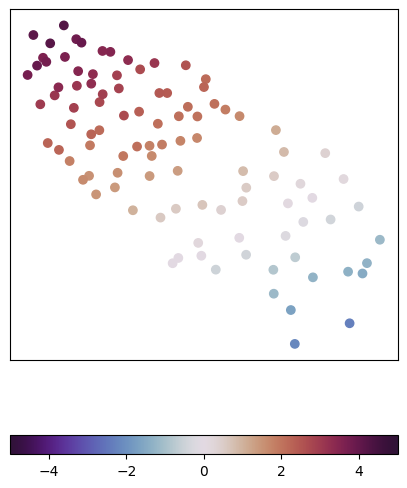

In [6]:
# build the space
np.random.seed(3)
embedding = MDS(n_components=2,dissimilarity = 'precomputed')
Decision_embedded = embedding.fit_transform(dm_decision)

# no text version
plt.figure(figsize=(5,6.5))
plt.scatter(Decision_embedded[:,0],Decision_embedded[:,1],c=scenario_summary['mean'],vmin=-5,vmax=5,cmap="twilight_shifted")
plt.colorbar(location='bottom')
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()

# Motivation Space

In [10]:
mot_factors = pd.read_csv('output/Factor_analysis/FA_scores.csv',index_col=0)
mot_factors

,MR1,MR2
S1,-0.145094,-2.455841
S2,-0.944945,1.390401
S3,0.890838,-0.239670
S4,-1.763357,-0.357930
S5,0.586377,-0.502944
...,...,...
S96,-0.014310,-0.906991
S97,0.191878,-2.138400
S98,-1.087086,-1.323241
S99,1.679752,-0.828944


In [11]:
# generate labels with median split
med_reward = mot_factors['MR1'].median()
med_cost = mot_factors['MR2'].median()
quadrant_label = []
for i in range(100):
    if mot_factors['MR1'].iloc[i] <= med_reward:
        if mot_factors['MR2'].iloc[i] <= med_cost:
            quadrant_label.append(3) # lower left quadrant, low reward, low cost
        else:
            quadrant_label.append(1) # upper left quadrant, low reward, high cost
    else:
        if mot_factors['MR2'].iloc[i] <= med_cost:
            quadrant_label.append(4) # lower right quadrant, high reward, low cost
        else:
            quadrant_label.append(2) # upper right quadrant, high reward, high cost


In [12]:
med_cost

0.048580707487554456

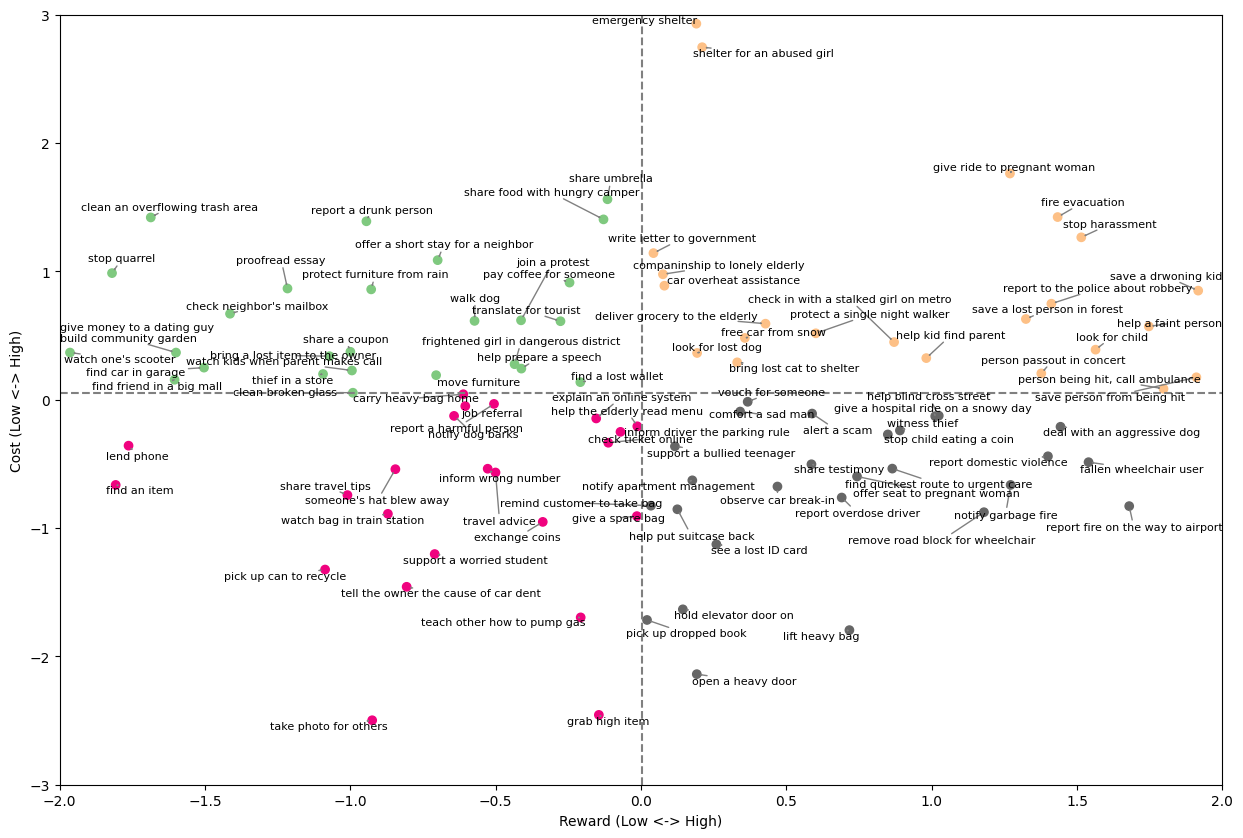

In [13]:
# visualize the 2D space
plt.figure(figsize=(15,10))
# plt.axvline(x=0,color='gray',ls='--') # mean
plt.axvline(med_reward,color='gray',ls='--') # median
# plt.axhline(y=0,color='gray',ls='--') # mean
plt.axhline(y=med_cost,color='gray',ls='--') # median
plt.scatter(mot_factors['MR1'],mot_factors['MR2'],c=quadrant_label,vmin=1,vmax=4,cmap="Accent")
texts = [plt.text(sample[0],sample[1],name,ha='center',va='center',size=8) for (sample,name) in zip(np.asarray(mot_factors), data['Label'])]
plt.xlabel('Reward (Low <-> High)')
plt.ylabel('Cost (Low <-> High)')
plt.xlim([-2,2])
plt.ylim([-3,3])
adjust_text(texts,arrowprops=dict(arrowstyle='->', color='gray'))

(-3.5, 3.5)

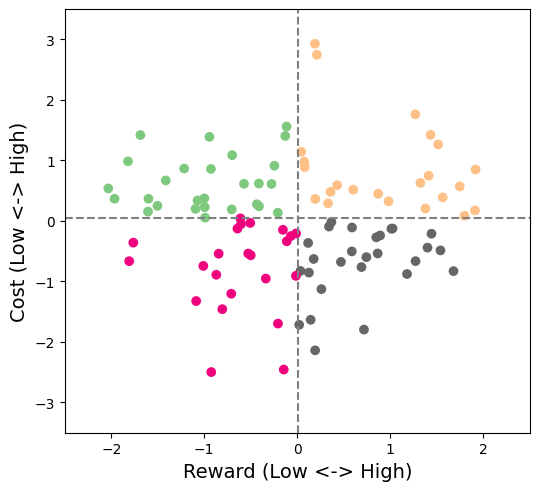

In [14]:
# no text label
plt.figure(figsize=(6,5.5))
plt.axvline(x=med_reward,color='gray',ls='--')
plt.axhline(y=med_cost,color='gray',ls='--')
plt.scatter(mot_factors['MR1'],mot_factors['MR2'],c=quadrant_label,cmap="Accent",vmin=1,vmax=4)
plt.xlabel('Reward (Low <-> High)',size=14)
plt.ylabel('Cost (Low <-> High)',size=14)
plt.xlim([-2.5,2.5])
plt.ylim([-3.5,3.5])

<Axes: >

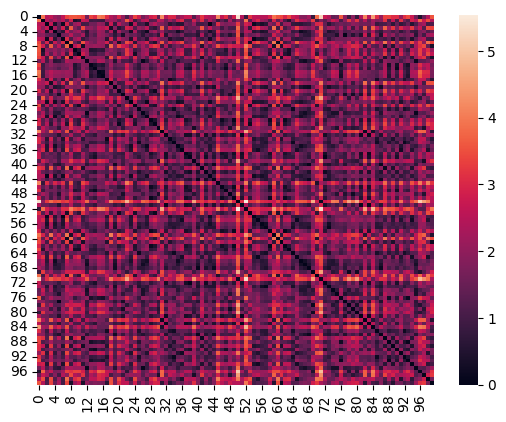

In [15]:
# calculate pairwise distance
dist_mot_cond = pdist(mot_factors, metric='euclidean')
dm_motivation = squareform(dist_mot_cond)
sns.heatmap(dm_motivation)

# Semantic Space

## Embedding and store output

In [240]:
# initialize openai api
client = OpenAI()
# get embedding
def get_embedding(text, model="text-embedding-3-small"):
   text = text.replace("\n", " ")
   return client.embeddings.create(input = [text], model=model,dimensions=256).data[0].embedding

In [5]:
# text-embedding-3-small
data['embedding'] = data.Scenario.apply(lambda x: get_embedding(x, model='text-embedding-3-small'))
data.to_csv('text_embedding/embedded_scenarios_3small.csv', index=False)

In [6]:
# text-embedding-3-large
data['embedding'] = data.Scenario.apply(lambda x: get_embedding(x, model='text-embedding-3-large'))
data.to_csv('text_embedding/embedded_scenarios_3large.csv', index=False)

## Visualize using t-SNE and UMAP

A useful blog about t-SNE: https://distill.pub/2016/misread-tsne/

### 3-small

In [7]:
path_small = "text_embedding/embedded_scenarios_3small.csv"
df_small = pd.read_csv(path_small)
# Convert to a list of lists of floats
matrix_small = np.array(df_small.embedding.apply(literal_eval).to_list())
# calculate the cosine distance
distance_matrix_small = pairwise_distances(matrix_small, matrix_small, metric='cosine', n_jobs=-1)

Text(0.5, 1.0, 'T-SNE Model small')

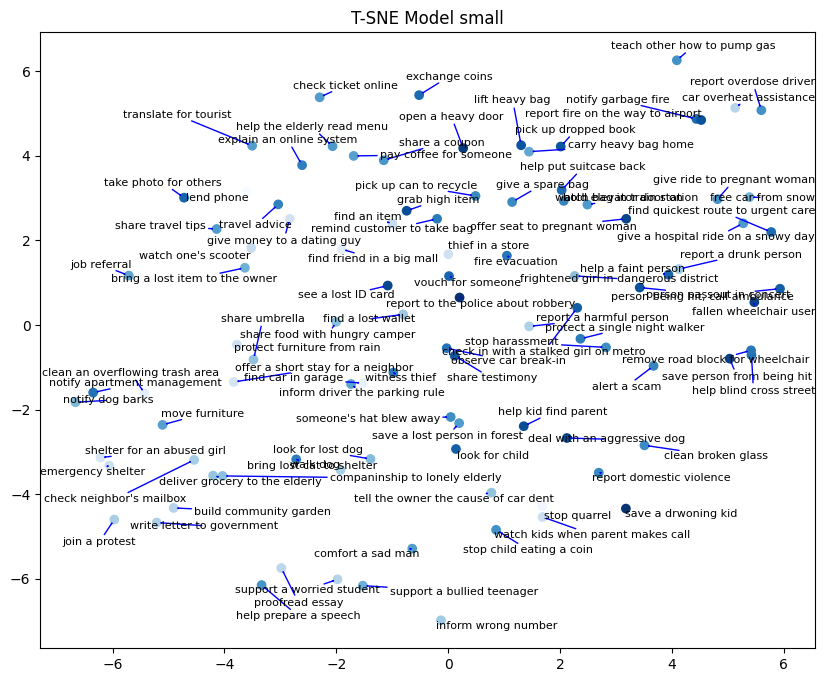

In [9]:
# Create a t-SNE model and transform the data
tsne = TSNE(n_components=2, perplexity=30, random_state=24, init='random', learning_rate=20, metric = "precomputed")
vis_small_tsne = tsne.fit_transform(distance_matrix_small)
# plot the tSNE
fig,ax = plt.subplots(figsize=(10,8))
ax.scatter(vis_small_tsne[:,0],vis_small_tsne[:,1],c=df_small['Mean willingness rating'],cmap='Blues')
texts = [plt.text(sample[0],sample[1],name,ha='center',va='center',size=8) for (sample,name) in zip(vis_small_tsne, df_small['Label'])]
adjust_text(texts,arrowprops=dict(arrowstyle='->', color='blue'))
ax.set_title('T-SNE Model small')

Text(0.5, 1.0, 'MDS Model small')

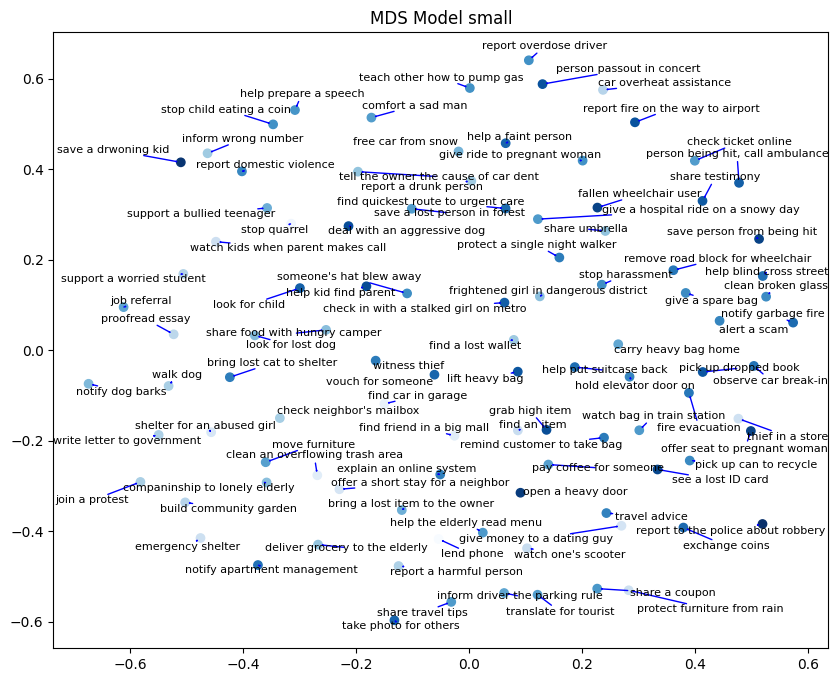

In [10]:
# MDS
mds = MDS(n_components=2, random_state=4, dissimilarity = "precomputed")
vis_small_mds = mds.fit_transform(distance_matrix_small)
# plot
fig,ax = plt.subplots(figsize=(10,8))
ax.scatter(vis_small_mds[:,0],vis_small_mds[:,1],c=df_small['Mean willingness rating'],cmap='Blues')
texts = [plt.text(sample[0],sample[1],name,ha='center',va='center',size=8) for (sample,name) in zip(vis_small_mds, df_small['Label'])]
adjust_text(texts,arrowprops=dict(arrowstyle='->', color='blue'))
ax.set_title('MDS Model small')

### 3-large

In [16]:
# visualize using t-SNE
path_large = "text_embedding/embedded_scenarios_3large.csv"
df_large = pd.read_csv(path_large)
# Convert to a list of lists of floats
matrix_large = np.array(df_large.embedding.apply(literal_eval).to_list())
# calculate the cosine distance
distance_matrix_large = pairwise_distances(matrix_large, metric='cosine', n_jobs=-1)

Text(0.5, 1.0, 'T-SNE Model large')

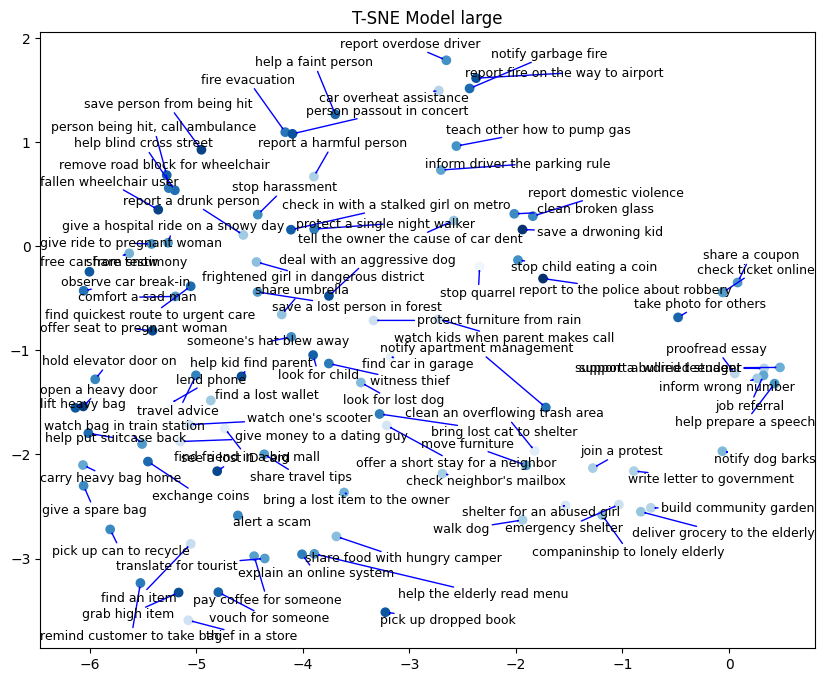

In [12]:
# Create a t-SNE model and transform the data
tsne = TSNE(n_components=2, perplexity=50, random_state=24, init='random', learning_rate=200)
vis_large_tsne = tsne.fit_transform(distance_matrix_large)

fig,ax = plt.subplots(figsize=(10,8))
ax.scatter(vis_large_tsne[:,0],vis_large_tsne[:,1],c=df_large['Mean willingness rating'],cmap='Blues')
texts = [plt.text(sample[0],sample[1],name,ha='center',va='center',size=9) for (sample,name) in zip(vis_large_tsne, df_large['Label'])]
adjust_text(texts,arrowprops=dict(arrowstyle='->', color='blue'))
ax.set_title('T-SNE Model large')

Text(0.5, 1.0, 'MDS Model large')

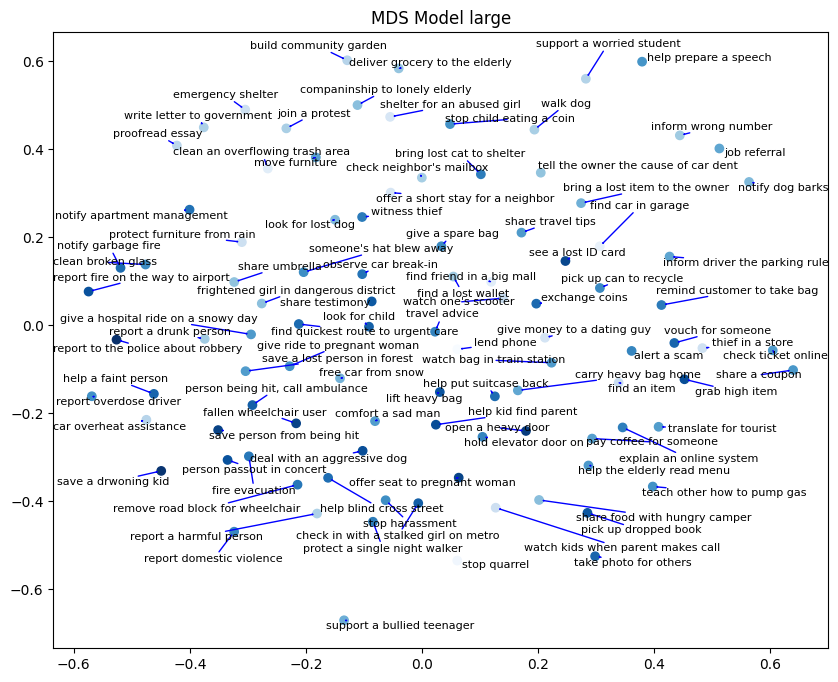

In [13]:
# MDS
mds = MDS(n_components=2, random_state=4, dissimilarity = "precomputed")
vis_large_mds = mds.fit_transform(distance_matrix_large)
# plot
fig,ax = plt.subplots(figsize=(10,8))
ax.scatter(vis_large_mds[:,0],vis_large_mds[:,1],c=df_large['Mean willingness rating'],cmap='Blues')
texts = [plt.text(sample[0],sample[1],name,ha='center',va='center',size=8) for (sample,name) in zip(vis_large_mds, df_large['Label'])]
adjust_text(texts,arrowprops=dict(arrowstyle='->', color='gray'))
ax.set_title('MDS Model large')

C:\Users\v0409128\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Text(0.5, 1.0, 'Text Embedding Space')

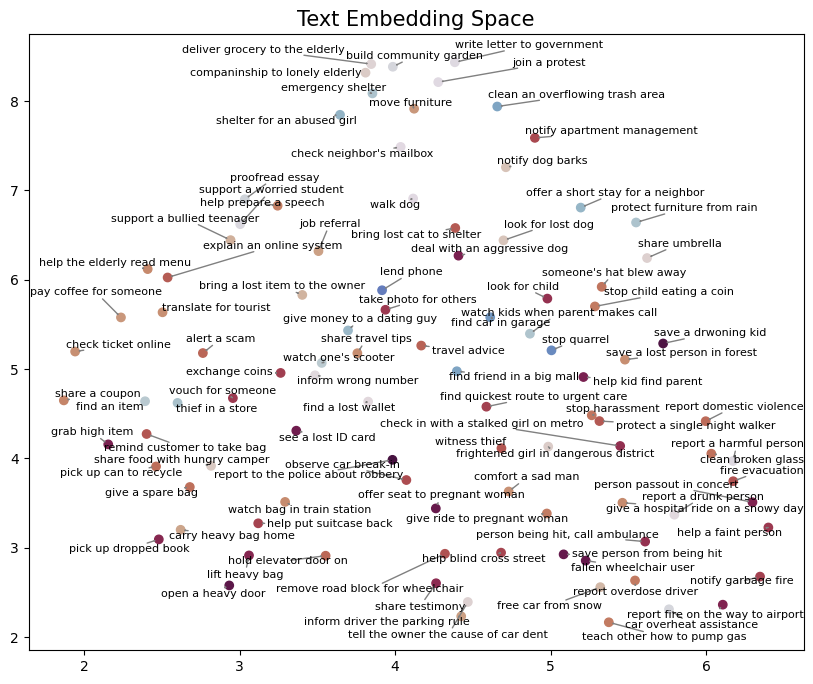

In [7]:
reducer = umap.UMAP(n_neighbors = 10, min_dist= 0.2, metric = 'cosine', random_state=14)
vis_large_umap = reducer.fit_transform(matrix_large)
fig,ax = plt.subplots(figsize=(10,8))
ax.scatter(vis_large_umap[:,0],vis_large_umap[:,1],c=df_large['Mean willingness rating'],vmin=-5,vmax=5,cmap="twilight_shifted")
texts = [plt.text(sample[0],sample[1],name,ha='center',va='center',size=8) for (sample,name) in zip(vis_large_umap, df_large['Label'])]
adjust_text(texts,arrowprops=dict(arrowstyle='->', color='gray'))
ax.set_title('Text Embedding Space', size=15)

It looks like the text embedding similarity is based on the semantic elements in each scenario. 
For example, scenarios relevant to 
- cars (car accident, car break-in, praking rule, etc.)-
- community/neighborhood duty (visit lonely elderly, build community garden, write letter to government, etc.)
- person with life threats (robbery, night walk, harass, etc.)
- road user (wheelchair user being blocked, person lie on the street, help blind cross street)
- stores (find an item, thief, remind to take bag, etc.)
- physical strength (pick up book, open door, lift bag)
- pets (agressive dog, walk dog, lost cat, etc.)
- kids related (stop eating coin, watch kids, find kids, save drowning kid)
- traveler (travel tips, find route)
- lost and found (find friend, find car, save a lost person, lost ID)
- Online request (proofread, support student, job referral)

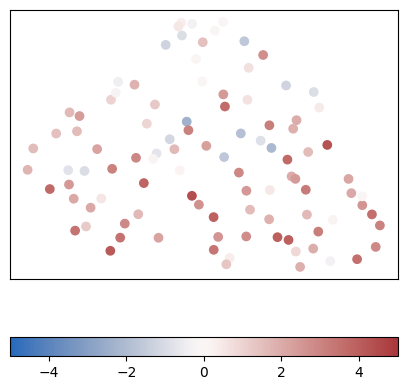

In [6]:
# no text version
plt.figure(figsize=(5,5))
plt.scatter(vis_large_umap[:,0],vis_large_umap[:,1],c=df_large['Mean willingness rating'],vmin=-5,vmax=5,cmap="vlag")
plt.colorbar(location='bottom')
#get current axes
ax = plt.gca()
#hide x-axis
ax.get_xaxis().set_visible(False)
#hide y-axis
ax.get_yaxis().set_visible(False)
plt.show()

### Compare the small and large model

Text(0.5, 1.0, 'Correlation r = 0.712')

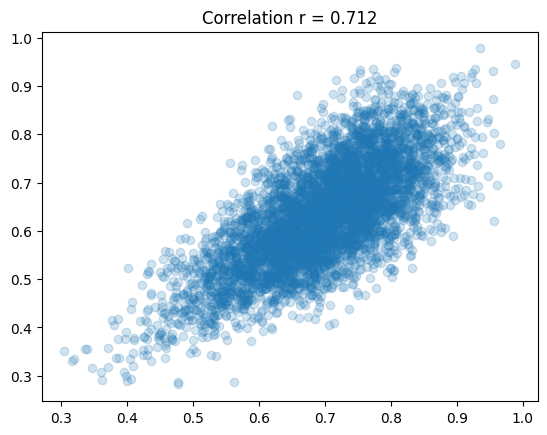

In [15]:
# compare small and large
plt.scatter(distance_matrix_small[np.triu_indices(100,k=1)],distance_matrix_large[np.triu_indices(100,k=1)], alpha=0.2)
pearsonr = np.corrcoef(distance_matrix_small[np.triu_indices(100,k=1)],distance_matrix_large[np.triu_indices(100,k=1)])
plt.title('Correlation r = ' + str(np.round(pearsonr[0,1],3)))

## Clustering
Try different clustering algorithm based on the 'large' output, and superimpose on the UMAP figure  
HDBSCAN didn't work

PCA cannot explain a lot of variance with small amount of PCs, let's do UMAP instead

In [17]:
# UMAP
reducer = umap.UMAP(n_neighbors = 10, min_dist= 0.2, metric = 'cosine',n_components=2, random_state=14)
vis_large_umap = reducer.fit_transform(matrix_large)

C:\Users\v0409128\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [18]:
# Affinity propagation
af_c = AffinityPropagation(damping=.9, max_iter=300, random_state=0).fit(vis_large_umap)
cluster_labels_aff = af_c.labels_
len(set(cluster_labels_aff))

9

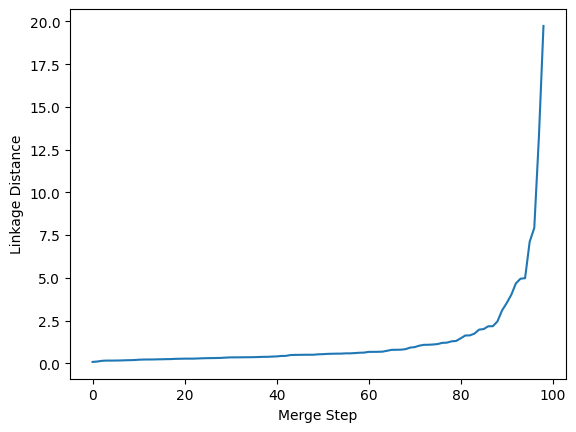

The elbow point is at: 2.1706961184065565


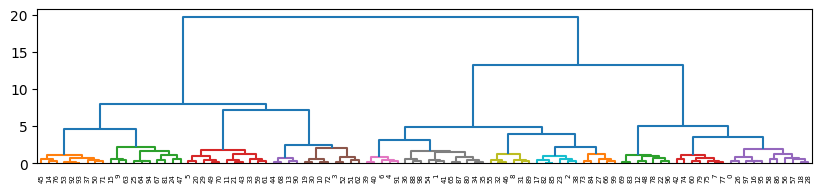

In [20]:
# Hierarchical clustering
distance_reduced = pairwise_distances(vis_large_umap, metric='euclidean')

condensed_dist_matrix = squareform(distance_reduced)
Z = linkage(condensed_dist_matrix, method='ward')  # You can change the method (e.g., 'complete', 'average')

 # Plot the distances at which clusters are merged
plt.plot(Z[:, 2]) 
plt.xlabel('Merge Step')
plt.ylabel('Linkage Distance')
plt.show()

# Fit KneeLocator on the linkage distances
knee_locator = KneeLocator(range(1, len(Z[:, 2]) + 1), Z[:, 2], curve='convex', direction='increasing')
# Get the elbow point
elbow_point = knee_locator.elbow-1
print(f"The elbow point is at: {Z[elbow_point,2]}")

# Plot the dendrogram
plt.figure(figsize=(10,2))
dendrogram(Z,color_threshold=Z[elbow_point,2])
plt.show()

cluster_labels_hier = fcluster(Z, Z[elbow_point,2], criterion='distance')


NameError: name 'n' is not defined

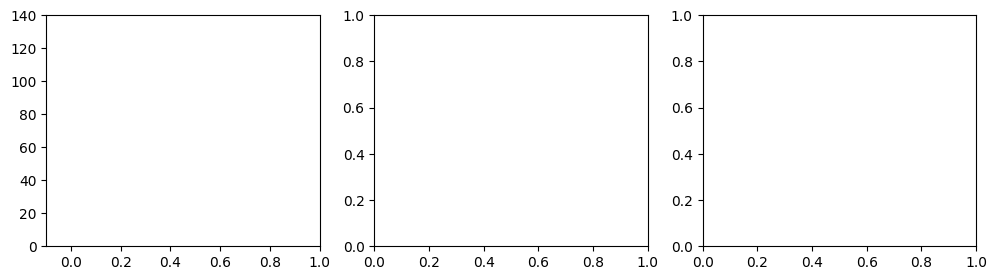

In [21]:
import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples
range_n_clusters = [3,5,10]
silhouette_avg_all = []

fig, axes = plt.subplots(1,3)
fig.set_size_inches(12, 3)

for (ax,n_clusters) in zip(axes.reshape(-1),range_n_clusters):

    ax.set_xlim([-0.1, 1])
    ax.set_ylim([0, len(vis_large_umap) + (n_clusters + 1) * 10])
    
    # start kmeans
    clusterer = KMeans(n_clusters=n, random_state=0, n_init="auto")
    cluster_labels = clusterer.fit_predict(vis_large_umap)

    # average score
    silhouette_avg=silhouette_score(vis_large_umap, cluster_labels)
    silhouette_avg_all.append(silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(vis_large_umap, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("Silhouette plot: K = " + str(n_clusters))
    ax.set_xlabel("The silhouette coefficient values",fontsize=12)
    ax.set_ylabel("Cluster label",fontsize=12)

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.3, wspace=0.3)
plt.show()

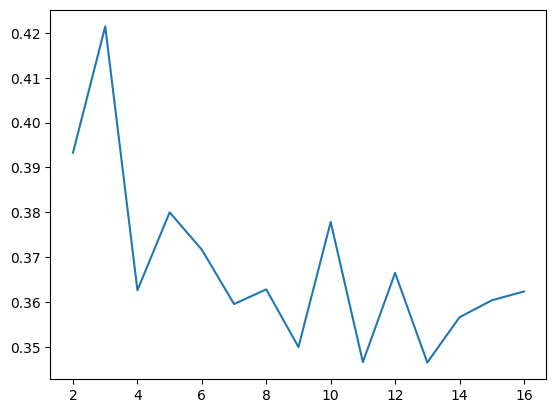

In [28]:
n_list = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
sil_score = []
for n in n_list:
    kmeans_n = KMeans(n_clusters=n, random_state=0, n_init="auto").fit(vis_large_umap)
    sil_score.append(silhouette_score(vis_large_umap, kmeans_n.labels_))
plt.plot(n_list,sil_score)


# select n
kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(vis_large_umap)
cluster_labels_kmeans = kmeans.labels_

In [32]:
# save all 3 types of labels
semantic_labels = pd.DataFrame(data = {
    'Scenario': data['Scenario'],
    'Label': data['Label'],
    'Affinity': cluster_labels_aff,
    'Hierarchical': cluster_labels_hier,
    'KMeans': cluster_labels_kmeans,
})
semantic_labels.index =  [f'S{i}' for i in range(1,101,1)]
semantic_labels.to_csv('output/Semantic_space_label/All_cluster_labels.csv')

NameError: name 'cluster_labels_kmeans' is not defined

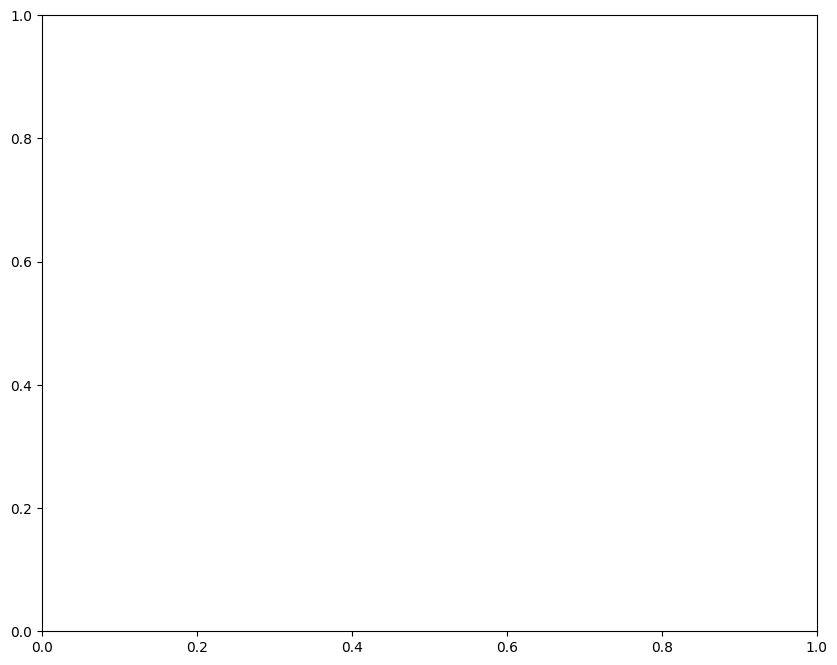

In [75]:
fig,ax = plt.subplots(figsize=(10,8))
ax.scatter(vis_large_umap[:,0],vis_large_umap[:,1],c=cluster_labels_kmeans,cmap="Accent")
texts = [plt.text(sample[0],sample[1],name,ha='center',va='center',size=8) for (sample,name) in zip(vis_large_umap, df_large['Label'])]
adjust_text(texts,arrowprops=dict(arrowstyle='->', color='gray'))
ax.set_title('Semantic Space: KMeans clustering', size=15)
fig.savefig('output/Semantic_space_label/Semantic_label_kmeans.svg', format='svg', dpi=500)

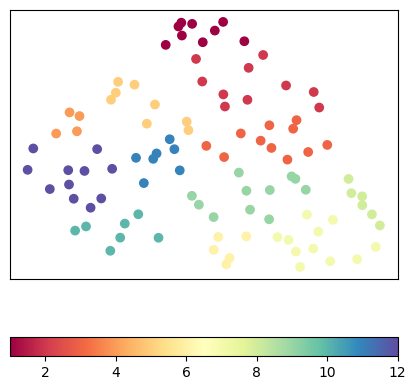

In [7]:
# no text version
plt.figure(figsize=(5,5))
plt.scatter(vis_large_umap[:,0],vis_large_umap[:,1],c=cluster_labels,cmap="Spectral")
plt.colorbar(location='bottom')
#get current axes
ax = plt.gca()
#hide x-axis
ax.get_xaxis().set_visible(False)
#hide y-axis
ax.get_yaxis().set_visible(False)
plt.show()

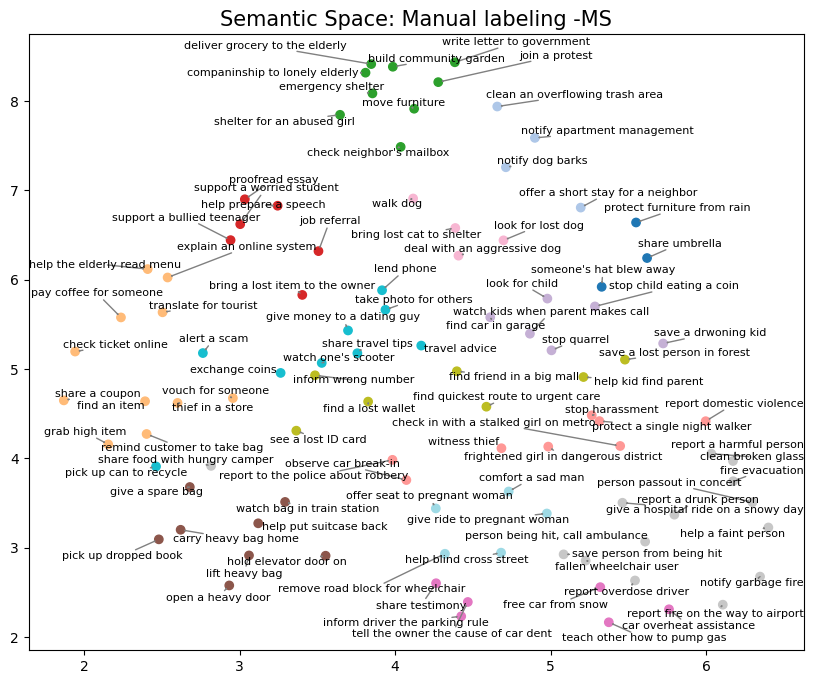

In [18]:
# visualize the manual label
scenario_manual = pd.read_excel('output/Semantic_space_label/All_cluster_labels_manual.xlsx',index_col=0)  

label_encoder = LabelEncoder()
label_encoded = label_encoder.fit_transform(scenario_manual['Manual_combine'])

fig,ax = plt.subplots(figsize=(10,8))
ax.scatter(vis_large_umap[:,0],vis_large_umap[:,1],c=label_encoded,cmap="tab20")
texts = [plt.text(sample[0],sample[1],name,ha='center',va='center',size=8) for (sample,name) in zip(vis_large_umap, df_large['Label'])]
adjust_text(texts,arrowprops=dict(arrowstyle='->', color='gray'))
ax.set_title('Semantic Space: Manual labeling -MS', size=15)
fig.savefig('output/Semantic_space_label/Semantic_label_manual_MS_combine.svg', format='svg', dpi=500)

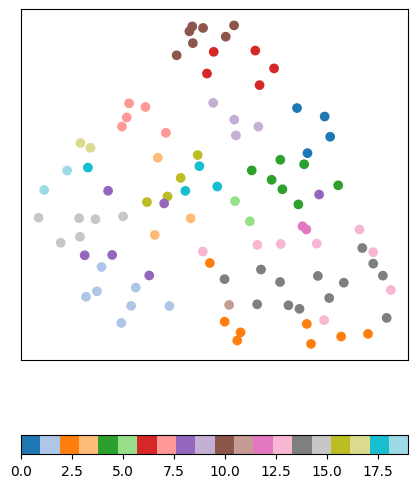

In [81]:
# no text version
plt.figure(figsize=(5,6.5))
plt.scatter(vis_large_umap[:,0],vis_large_umap[:,1],c=label_encoded,cmap="tab20")
plt.colorbar(location='bottom')
#get current axes
ax = plt.gca()
#hide x-axis
ax.get_xaxis().set_visible(False)
#hide y-axis
ax.get_yaxis().set_visible(False)
plt.show()

### Compare the distance before and after dimensionality reduction

Text(0.5, 1.0, 'Correlation r = 0.464')

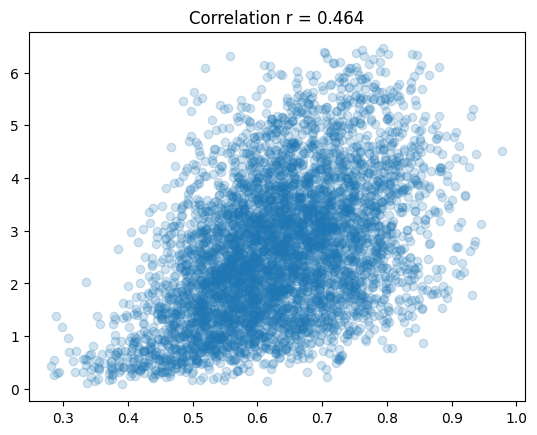

In [135]:
# compare small and large
plt.scatter(distance_matrix_large[np.triu_indices(100,k=1)],distance_reduced[np.triu_indices(100,k=1)], alpha=0.2)
pearsonr = np.corrcoef(distance_matrix_large[np.triu_indices(100,k=1)],distance_reduced[np.triu_indices(100,k=1)])
plt.title('Correlation r = ' + str(np.round(pearsonr[0,1],3)))

# Representational Similarity Analysis

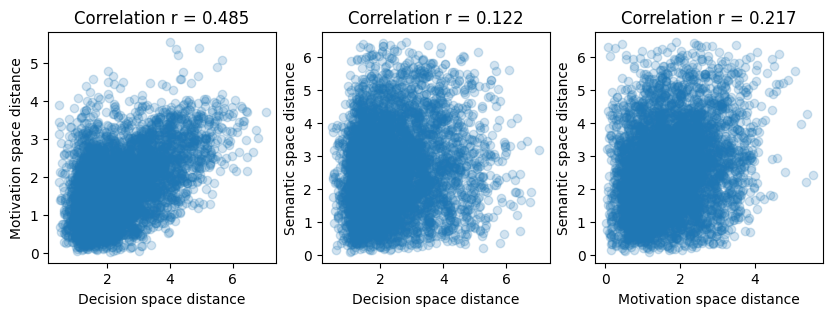

In [22]:
# calculate the correlation
dm_semantic = distance_reduced # distance_matrix_large

fig,axes = plt.subplots(1,3,figsize=(10,3))
# decision vs. motivation
axes[0].scatter(dm_decision[np.triu_indices(100,k=1)],dm_motivation[np.triu_indices(100,k=1)], alpha=0.2)
corr_decision_motivation = np.corrcoef(dm_decision[np.triu_indices(100,k=1)],dm_motivation[np.triu_indices(100,k=1)])
axes[0].set_title('Correlation r = ' + str(np.round(corr_decision_motivation[0,1],3)))
axes[0].set_xlabel('Decision space distance')
axes[0].set_ylabel('Motivation space distance')
# decision vs. semantic
axes[1].scatter(dm_decision[np.triu_indices(100,k=1)],dm_semantic[np.triu_indices(100,k=1)], alpha=0.2)
corr_decision_semantic = np.corrcoef(dm_decision[np.triu_indices(100,k=1)],dm_semantic[np.triu_indices(100,k=1)])
axes[1].set_title('Correlation r = ' + str(np.round(corr_decision_semantic[0,1],3)))
axes[1].set_xlabel('Decision space distance')
axes[1].set_ylabel('Semantic space distance')
# motivation vs. semantic
axes[2].scatter(dm_motivation[np.triu_indices(100,k=1)],dm_semantic[np.triu_indices(100,k=1)], alpha=0.2)
corr_motivation_semantic = np.corrcoef(dm_motivation[np.triu_indices(100,k=1)],dm_semantic[np.triu_indices(100,k=1)])
axes[2].set_title('Correlation r = ' + str(np.round(corr_motivation_semantic[0,1],3)))
axes[2].set_xlabel('Motivation space distance')
axes[2].set_ylabel('Semantic space distance')
plt.show()

In [83]:
# Permutation test of statistical significance
def RSA_p_permutation(dm_1, dm_2, n_perm):
    # perform permutations on the row&column orders of dm_1, and calculate an empirical null distribution of the correlation with dm_2
    # dm_1 and dm_2 are both squareform np.ndarrays
    null_r = np.zeros((n_perm,1))
    for perm in range(n_perm):
        new_order = random.sample(np.arange(0,100).tolist(),100)
        dm_1_shuffle = dm_1[new_order][:, new_order]
        pearsonr = np.corrcoef(dm_1_shuffle[np.triu_indices(100,k=1)],dm_2[np.triu_indices(100,k=1)])
        null_r[perm] = pearsonr[0,1]
    # calculate the p
    true_r = np.corrcoef(dm_1[np.triu_indices(100,k=1)],dm_2[np.triu_indices(100,k=1)])[0,1]
    p = (np.sum(true_r<null_r))/n_perm
    return null_r, true_r, p

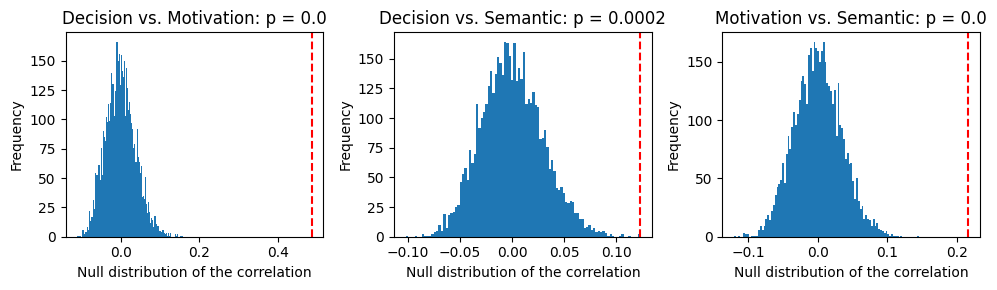

In [84]:
# calculate the permutation test
fig, axes = plt.subplots(1,3,figsize=(10,3))
# decision vs. motivation
null_r_decision_motivation,true_r_decision_motivation, p_decision_motivation = RSA_p_permutation(dm_decision, dm_motivation, 5000)
axes[0].hist(null_r_decision_motivation,bins=100)
axes[0].axvline(x=true_r_decision_motivation,color='red',ls='--')
axes[0].set_title(f'Decision vs. Motivation: p = {p_decision_motivation}')
axes[0].set_xlabel('Null distribution of the correlation')
axes[0].set_ylabel('Frequency')
# decision vs. semantic
null_r_decision_semantic,true_r_decision_semantic, p_decision_semantic = RSA_p_permutation(dm_decision, dm_semantic, 5000)
axes[1].hist(null_r_decision_semantic,bins=100)
axes[1].axvline(x=true_r_decision_semantic,color='red',ls='--')
axes[1].set_title(f'Decision vs. Semantic: p = {p_decision_semantic}')
axes[1].set_xlabel('Null distribution of the correlation')
axes[1].set_ylabel('Frequency')
# motivation vs. semantic
null_r_motivation_semantic,true_r_motivation_semantic, p_motivation_semantic = RSA_p_permutation(dm_motivation, dm_semantic, 5000)
axes[2].hist(null_r_motivation_semantic,bins=100)
axes[2].axvline(x=true_r_motivation_semantic,color='red',ls='--')
axes[2].set_title(f'Motivation vs. Semantic: p = {p_motivation_semantic}')
axes[2].set_xlabel('Null distribution of the correlation')
axes[2].set_ylabel('Frequency')

plt.tight_layout()

# Pairwise associations

## Decision space vs. Motivation space

Overlay the WTH ratings to the motivation space

In [13]:
mot_factors['Quadrant'] = quadrant_label
mot_factors['WTH'] = scenario_summary['mean']

(-3.5, 3.5)

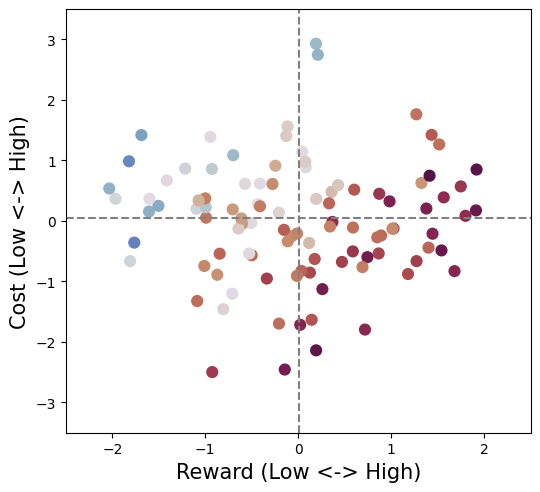

In [68]:
# color the motivation space with WTH ratings
plt.figure(figsize=(6,5.5))
plt.axvline(x=med_reward,color='gray',ls='--')
plt.axhline(y=med_cost,color='gray',ls='--')
plt.scatter(mot_factors['MR1'],mot_factors['MR2'],c=mot_factors['WTH'],s =60, vmin=-5,vmax=5,cmap="twilight_shifted")
plt.xlabel('Reward (Low <-> High)',size=15)
plt.ylabel('Cost (Low <-> High)',size=15)
plt.xlim([-2.5,2.5])
plt.ylim([-3.5,3.5])

Text(0.5, 0, 'Quadrant')

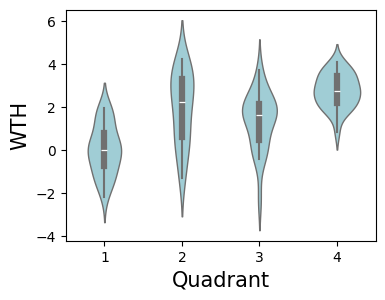

In [89]:
# compare the WTH rating across 4 quadrants
plt.figure(figsize=(4,3))
sns.violinplot(data=mot_factors, x="Quadrant", y="WTH", color = '#9ad1db',width=0.6, saturation=0.8, linewidth=1)
plt.ylabel('WTH',size=15)
plt.xlabel('Quadrant',size=15)
#plt.yticks([-3, -2, -1, 0])
#plt.set_yticklabels(['Low Reward, High Cost','High Reward, High Cost','Low Reward, Low Cost','High Reward, High Cost'])  # Reverse the labels

In [88]:
model = ols('WTH ~ C(Quadrant)', data=mot_factors).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

tukey = pairwise_tukeyhsd(endog=mot_factors['WTH'], groups=mot_factors['Quadrant'], alpha=0.05)
print(tukey)

                 sum_sq    df          F        PR(>F)
C(Quadrant)  107.461377   3.0  22.610153  3.708338e-11
Residual     152.089375  96.0        NaN           NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     1      2   1.9392    0.0  1.0054  2.873   True
     1      3   1.3484 0.0016  0.4146 2.2823   True
     1      4   2.7435    0.0  1.8478 3.6391   True
     2      3  -0.5908 0.3882 -1.5612 0.3797  False
     2      4   0.8042 0.1169 -0.1296  1.738  False
     3      4    1.395  0.001  0.4612 2.3288   True
---------------------------------------------------


Overylay motivation ratings on the decision space

Text(0.5, 1.0, 'Color by Quadrant')

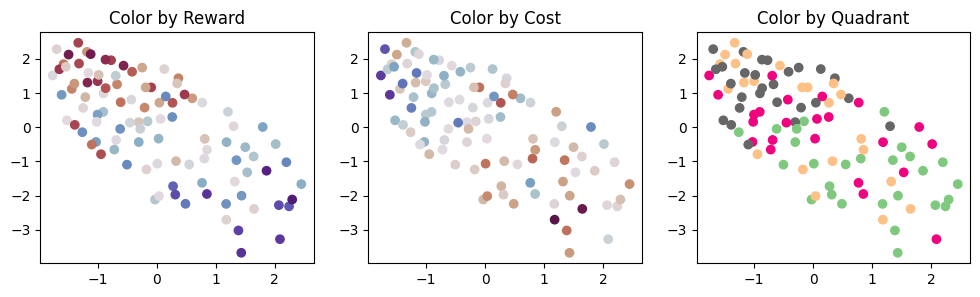

In [91]:
fig, axes = plt.subplots(1,3,figsize=(12,3))
axes[0].scatter(Decision_embedded[:,0],Decision_embedded[:,1],c=mot_factors['MR1'],vmin=-2.5,vmax=2.5,cmap="twilight_shifted")
axes[0].set_title('Color by Reward')
axes[1].scatter(Decision_embedded[:,0],Decision_embedded[:,1],c=mot_factors['MR2'],vmin=-3.5,vmax=3.5,cmap="twilight_shifted")
axes[1].set_title('Color by Cost')
axes[2].scatter(Decision_embedded[:,0],Decision_embedded[:,1],c=mot_factors['Quadrant'],cmap="Accent")
axes[2].set_title('Color by Quadrant')

## Deicion space vs. semantic space

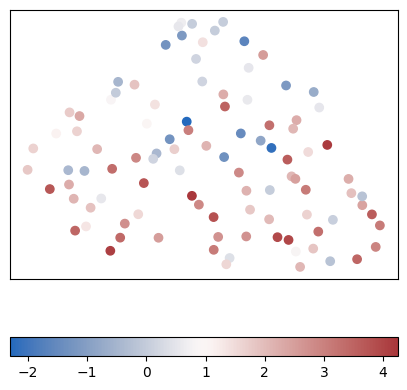

In [92]:
# overlay WTH on semantic space
plt.figure(figsize=(5,5))
plt.scatter(vis_large_umap[:,0],vis_large_umap[:,1],c=scenario_summary['mean'],cmap="vlag")
plt.colorbar(location='bottom')
#get current axes
ax = plt.gca()
#hide x-axis
ax.get_xaxis().set_visible(False)
#hide y-axis
ax.get_yaxis().set_visible(False)
plt.show()

In [102]:
scenario_manual['Manual']
scenario_summary['Semantic_label'] = scenario_manual['Manual'].values
scenario_summary

,mean,SD,n,help_prop,SD_prop,Semantic_label
S1,3.730769,1.891374,104,0.961538,0.193239,store
S2,0.067961,2.948120,103,0.553398,0.499571,safety (health)
S3,2.154639,2.884370,97,0.783505,0.413995,safety (crime)
S4,-2.301887,2.589980,106,0.226415,0.420499,street
S5,3.099010,2.504017,101,0.891089,0.313081,driving
...,...,...,...,...,...,...
S96,1.912621,2.811415,103,0.796117,0.404853,carry/lift/hold
S97,4.102804,1.380009,107,0.981308,0.136071,carry/lift/hold
S98,2.106796,2.920222,103,0.776699,0.418495,other
S99,3.457143,2.324736,105,0.904762,0.294951,driving


Text(0, 0.5, 'WTH')

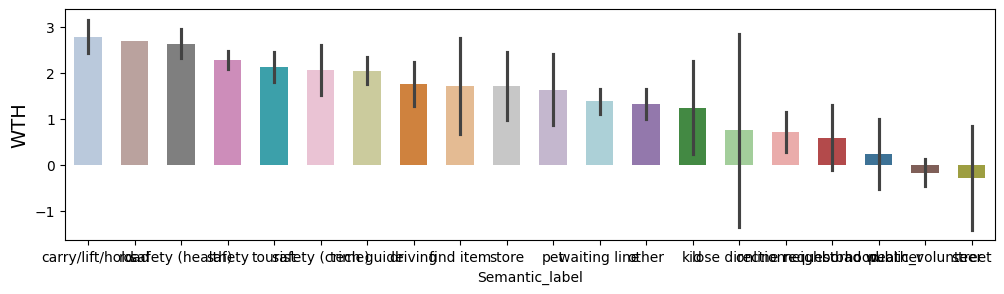

In [65]:
# whether there are diff. in the overall ratings across different semantic categories
label_encoder = LabelEncoder()
label_encoded = label_encoder.fit_transform(scenario_manual['Manual'])
scenario_summary['Semantic_label'] = scenario_manual['Manual'].values
scenario_summary['label_numeric'] = label_encoded

order = scenario_summary.groupby('Semantic_label')['mean'].mean().sort_values(ascending = False).index

# visualize the differences
plt.figure(figsize=(12,3))
sns.barplot(data=scenario_summary, x="Semantic_label", y="mean",hue = "label_numeric",errorbar = "se", order = order,
            palette = "tab20",width=0.6, saturation=0.6, linewidth=1, legend = False)
plt.ylabel('WTH',size=14)


In [129]:
#import statsmodels.api as sm
#from statsmodels.formula.api import ols
#from scipy import stats

model = ols('mean ~ C(Semantic_label)', data=scenario_summary).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=scenario_summary['mean'], groups=scenario_summary['Semantic_label'], alpha=0.05)
#print(tukey)

                       sum_sq    df         F    PR(>F)
C(Semantic_label)   84.136257  19.0  2.019548  0.016034
Residual           175.414495  80.0       NaN       NaN


In [274]:
# ask chatgpt to summarize the docs
client = OpenAI()

stream = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[{"role": "user", "content": "Say this is a test"}],
    stream=True,
)

def get_cluster_topics(documents, cluster_label):
    # Prepare the documents to send to the API as context
    documents_str = "\n\n".join(documents)
    
    # Prepare the prompt for ChatGPT
    prompt = (
        f"I have a set of {len(documents)} documents that belong to the same cluster (Cluster {cluster_label}). "
        f"Please summarize the main topics or themes that these documents are about.\n\n"
        f"Note that I only need the commonalities of these documents, so please summarize all of them using one sentence.\n\n"
        f"Here are the documents:\n{documents_str}\n\n"
        "Please provide a list of key topics based on these documents."
    )
    
    # Send the request to the Chat API (using the correct endpoint)
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",  # You can also use 'gpt-4' if you have access
        messages=[
            {"role": "system", "content": "You are an expert in analyzing document topics."},
            {"role": "user", "content": prompt}
        ],
        max_tokens=500,  # Adjust token limit based on document size
        temperature=0.7  # Adjust temperature if needed
    )
    
    # Extract and return the assistant's response (topics)
    return response.choices[0].message.content


# Sample documents and cluster labels
documents = data['Scenario']

# Organize documents by cluster
clustered_documents = {}
for doc, label in zip(documents, cluster_labels):
    if label not in clustered_documents:
        clustered_documents[label] = []
    clustered_documents[label].append(doc)

# Iterate over clusters and get topics for each
for cluster_label, docs in clustered_documents.items():
    print(f"\nIdentifying topics for Cluster {cluster_label}:")
    topics = get_cluster_topics(docs, cluster_label)
    print(f"Topics for Cluster {cluster_label}:\n{topics}")



Identifying topics for Cluster 12:
Topics for Cluster 12:
Based on the provided documents in Cluster 12, the key topics can be summarized as situations involving observation and potential actions in various scenarios to help others in need or prevent harm, such as assisting with reaching items, sharing resources, preventing theft, offering help in technological challenges, and aiding in unexpected situations.

Identifying topics for Cluster 7:
Topics for Cluster 7:
Based on the set of documents provided, the key topics can be summarized as:
- Emergency situations requiring immediate assistance and intervention to help individuals in distress and prevent potential harm or accidents.

Identifying topics for Cluster 9:
Topics for Cluster 9:
Based on the documents provided, the key topics can be summarized as: Observing suspicious or concerning behaviors in public spaces and the need for intervention or assistance to ensure safety and well-being.

Identifying topics for Cluster 5:
Topics 

Superimpose the semantic label on the decision space

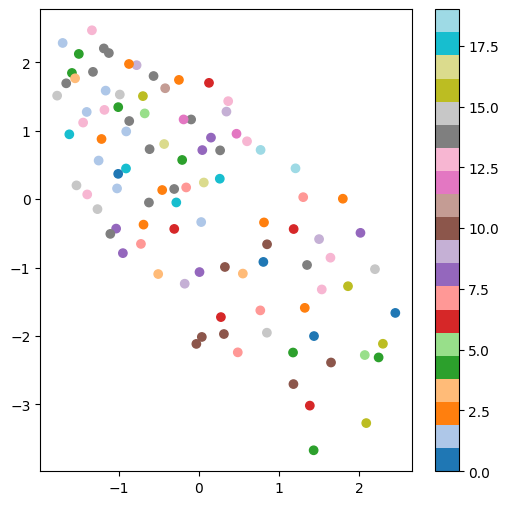

In [120]:
plt.figure(figsize=(6,6))
plt.scatter(Decision_embedded[:,0],Decision_embedded[:,1],c=scenario_summary['label_numeric'],cmap="tab20")
plt.colorbar(location='right')
#get current axes
ax = plt.gca()
plt.show()

## Motivation space vs. semantic space

Overylay Motivation Factors on semantic space

Text(0.5, 1.0, 'Color by Quadrant')

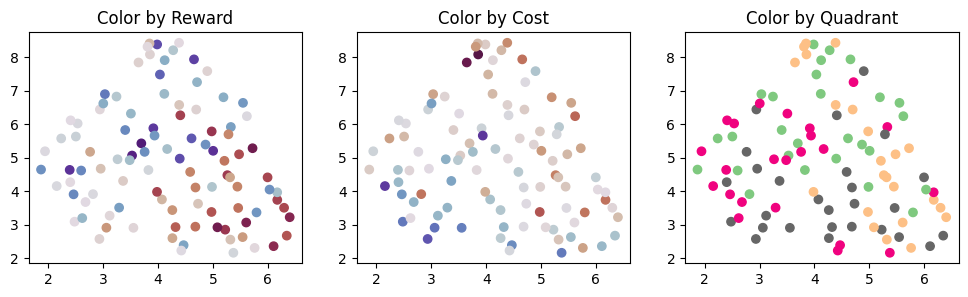

In [121]:
fig, axes = plt.subplots(1,3,figsize=(12,3))
axes[0].scatter(vis_large_umap[:,0],vis_large_umap[:,1],c=mot_factors['MR1'],vmin=-2.5,vmax=2.5,cmap="twilight_shifted")
axes[0].set_title('Color by Reward')
axes[1].scatter(vis_large_umap[:,0],vis_large_umap[:,1],c=mot_factors['MR2'],vmin=-3.5,vmax=3.5,cmap="twilight_shifted")
axes[1].set_title('Color by Cost')
axes[2].scatter(vis_large_umap[:,0],vis_large_umap[:,1],c=mot_factors['Quadrant'],cmap="Accent")
axes[2].set_title('Color by Quadrant')

Overlay Semantic space label to motivation space

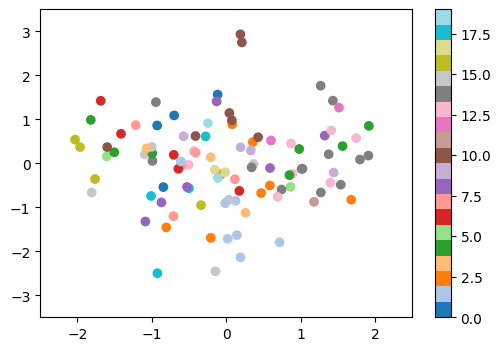

In [122]:
plt.figure(figsize=(6,4))
plt.scatter(mot_factors['MR1'],mot_factors['MR2'],c=scenario_summary['label_numeric'],cmap="tab20")
plt.colorbar(location='right')
plt.xlim([-2.5,2.5])
plt.ylim([-3.5,3.5])
plt.show()

C:\Users\v0409128\AppData\Local\Temp\ipykernel_19256\137944966.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(scenario_summary['Semantic_label'], rotation=45, ha='right', size = 14)


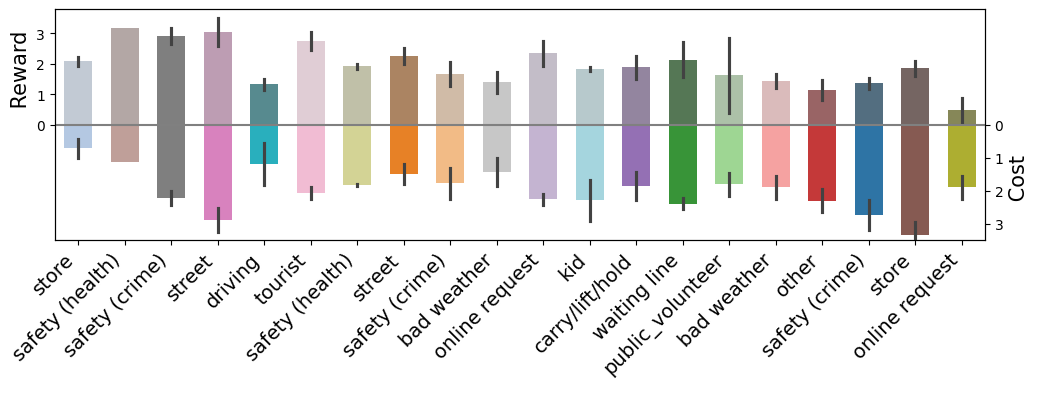

In [79]:
# visualize the differences
scenario_summary['Reward'] = mot_factors['MR1']
scenario_summary['Cost'] = mot_factors['MR2']

scenario_summary['Reward_transformed'] = scenario_summary['Reward'] + 2
scenario_summary['Cost_transformed'] = -(scenario_summary['Cost'] + 2)

x_shifted = np.arange(len(scenario_summary['Semantic_label'])) + 0.3

fig,ax = plt.subplots(figsize=(12,3))
sns.barplot(data=scenario_summary, x="Semantic_label", y="Reward_transformed",hue = "label_numeric",errorbar = "se",order=order,
            palette = "tab20",width=0.6, saturation=0.3, linewidth=1, legend = False, ax = ax)
ax.set_ylim([-3.8,3.8])
ax.set_ylabel('                 Reward',size = 15)
ax.set_xticklabels(scenario_summary['Semantic_label'], rotation=45, ha='right', size = 14)
ax.set_xlabel(' ')
ax.set_yticks([0, 1, 2, 3])
ax2 = ax.twinx()
sns.barplot(data=scenario_summary, x="Semantic_label", y="Cost_transformed",hue = "label_numeric",errorbar = "se",order=order,
            palette = "tab20",width=0.6, saturation=0.8, linewidth=1, legend = False, ax = ax2)
ax2.set_ylim([-3.5,3.5])
plt.axhline(0,color="gray")
ax2.set_ylabel('      Cost',size=15, loc = 'bottom')
ax2.set_yticks([-3, -2, -1, 0])
ax2.set_yticklabels([3, 2, 1, 0])  # Reverse the labels
plt.show()

# Link all 3 spaces

The decision space consist of (1) a main axis of the mean WTH rating, and (2) some additional variance.  
(1) is likely predictable by the other 2 spaces  
(2) is not clear  

To confirm the first hypothesis and explore the second, let's do the following:
1. Predict a uni-dimensional similarity by (1) using i) reward, ii) cost, and iii) semantic similarity
2. Predict the overall decision space similarity by i) uni-dimensional WTH similarity, ii) reward, iii) cost, and iv) semantic similarity


In [28]:
# first calculate the uni-dimensional similarity
# WTH rating
dm_WTH_1d =pdist(np.asarray(scenario_summary['mean']).reshape(-1,1), metric='euclidean')
# reward
dm_reward_1d = pdist(np.asarray(mot_factors['MR1']).reshape(-1,1), metric='euclidean')
# cost
dm_cost_1d = pdist(np.asarray(mot_factors['MR2']).reshape(-1,1), metric='euclidean')
# then put them altogether in a dataframe
dm_regression = pd.DataFrame(data = 
                             {'WTH_1d': dm_WTH_1d,
                              'Reward_1d': dm_reward_1d,
                              'Cost_1d': dm_cost_1d,
                              'Decision_2d': squareform(dm_decision),
                              'Motivation_2d': squareform(dm_motivation),
                              'Semantic_2d': squareform(dm_semantic)})

dm_regression = dm_regression.apply(stats.zscore)

## Predict WTH similarity using motivation and semantic space

In [29]:
# Using statsmodels
X = dm_regression[['Reward_1d', 'Cost_1d', 'Semantic_2d']]  # Add as many predictors as needed
# Add a constant to the model (intercept)
X = sm.add_constant(X)
# Define the dependent variable (target)
y = dm_regression['WTH_1d']

# Fit the model
model = sm.OLS(y, X).fit()

# Print the model summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                 WTH_1d   R-squared:                       0.264
Model:                            OLS   Adj. R-squared:                  0.263
Method:                 Least Squares   F-statistic:                     590.6
Date:                Wed, 25 Sep 2024   Prob (F-statistic):               0.00
Time:                        11:14:51   Log-Likelihood:                -6265.9
No. Observations:                4950   AIC:                         1.254e+04
Df Residuals:                    4946   BIC:                         1.257e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -2.439e-09      0.012     -2e-07      

## Understand the rest of the variances in the deicsion space

In [30]:
# Using statsmodels
X2 = dm_regression[['WTH_1d']]
                  #  ,'Reward_1d', 'Cost_1d', 'Semantic_2d']]  # Add as many predictors as needed
# Add a constant to the model (intercept)
X2 = sm.add_constant(X2)
# Define the dependent variable (target)
y2 = dm_regression['Decision_2d']
# Fit the model
model2 = sm.OLS(y2, X2).fit()
# Print the model summary
print(model2.summary())


                            OLS Regression Results                            
Dep. Variable:            Decision_2d   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                 4.445e+04
Date:                Wed, 25 Sep 2024   Prob (F-statistic):               0.00
Time:                        11:15:02   Log-Likelihood:                -1328.8
No. Observations:                4950   AIC:                             2662.
Df Residuals:                    4948   BIC:                             2675.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.056e-16      0.004  -4.57e-14      1.0

In [31]:
#create instance of influence
influence = model2.get_influence()

#obtain standardized residuals
res_decision2D = influence.resid_studentized_internal

X2_1 = dm_regression[['Reward_1d', 'Cost_1d', 'Semantic_2d']]  # Add as many predictors as needed
# Add a constant to the model (intercept)
X2_1 = sm.add_constant(X2_1)
# Fit the model
model2_1 = sm.OLS(res_decision2D, X2_1).fit()
# Print the model summary
print(model2_1.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     7.655
Date:                Wed, 25 Sep 2024   Prob (F-statistic):           4.21e-05
Time:                        11:15:05   Log-Likelihood:                -7012.3
No. Observations:                4950   AIC:                         1.403e+04
Df Residuals:                    4946   BIC:                         1.406e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        3.205e-05      0.014      0.002      

It seems like the semantic space sig. predict the decision space variance (aside from the WTH continumm). How much proportion of variance does it explain?

In [128]:
X3 = dm_regression[['WTH_1d','Reward_1d', 'Cost_1d']]  # Add as many predictors as needed
X3 = sm.add_constant(X3)
# Define the dependent variable (target)
y3 = dm_regression['Decision_2d']
# Fit the model
model3 = sm.OLS(y3, X3).fit()
# Print the model summary
print(model3.summary())


                            OLS Regression Results                            
Dep. Variable:            Decision_2d   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                 1.481e+04
Date:                Mon, 16 Sep 2024   Prob (F-statistic):               0.00
Time:                        18:35:22   Log-Likelihood:                -1851.8
No. Observations:                4950   AIC:                             3712.
Df Residuals:                    4946   BIC:                             3738.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9606      0.011     85.030      0.0

# Organize all data
Summarize all three spaces in a single dataframe

In [15]:
data_three_spaces = pd.DataFrame(data = {
    'Scenario': data['Scenario'],
    'Action': data['Task 2 Action Prompt'],
    'Label': data['Label'],
    'Decision_x': Decision_embedded[:,0],
    'Decision_y': Decision_embedded[:,1],
    'WTH': scenario_summary['mean'].reset_index(drop=True),
    'Motivation_reward': mot_factors['MR1'].reset_index(drop=True),
    'Motivation_cost': mot_factors['MR2'].reset_index(drop=True),
    'Motivation_label': mot_factors['Quadrant'].reset_index(drop=True),
    'Semantic_x': vis_large_umap[:,0],
    'Semantic_y': vis_large_umap[:,1],
    'Semantic_label':cluster_labels_hier,
})
data_three_spaces.index =  mot_factors['MR1'].index
data_three_spaces

,Scenario,Action,Label,Decision_x,Decision_y,WTH,Motivation_reward,Motivation_cost,Motivation_label,Semantic_x,Semantic_y,Semantic_label
S1,You are doing your weekly grocery shopping in ...,This person needs someone to grab the tomato p...,grab high item,-1.765045,1.514770,3.730769,-0.145094,-2.455841,3,2.153924,4.157400,12
S2,"Sunday, 1am - You were having a very nice drin...","To help the drunk man, someone needs to stay h...",report a drunk person,1.349625,-0.961086,0.067961,-0.944945,1.390401,1,5.796814,3.370692,7
S3,9pm - You arrive early to meet with a friend a...,"To reduce loss of the house owner, you can rep...",witness thief,0.366823,1.434196,2.154639,0.890838,-0.239670,4,4.683960,4.114389,9
S4,You are walking in the city center. Waiting fo...,The person needs to use someone's phone for 10...,lend phone,2.087646,-3.272560,-2.301887,-1.763357,-0.357930,3,3.915755,5.882032,5
S5,You just finish shopping and head to the parki...,"To help the sedan driver recover lost, the wit...",share testimony,-0.246953,1.744878,3.099010,0.586377,-0.502944,4,4.263305,2.603460,6
...,...,...,...,...,...,...,...,...,...,...,...,...
S96,"While driving through a residential area, you ...",The person hopes a passer-by can stop and giv...,give a spare bag,-1.018359,0.158228,1.912621,-0.014310,-0.906991,3,2.678818,3.680307,12
S97,You are in a building to conduct some business...,The person wants someone to hold the door for ...,open a heavy door,-1.696070,2.285102,4.102804,0.191878,-2.138400,4,2.932632,2.578793,10
S98,"While walking down the street, you notice a pe...",It will be helpful if someone can pick up the ...,pick up can to recycle,0.152320,0.901101,2.106796,-1.087086,-1.323241,3,2.461608,3.910191,12
S99,You are driving to the airport to catch an imp...,To control the flame and avoid loss of nearby ...,report fire on the way to airport,-0.869422,1.977708,3.457143,1.679752,-0.828944,4,6.108219,2.363449,7


In [16]:
data_three_spaces.to_csv('output/data_three_spaces.csv')